# Absorption, Simulation, Observation, Oh My!

In this notebook we will load in data of column densities estimated from simulations of galactic winds to compare to an observation of a starbursting galaxy. We will then use a minimum chi-squared best fit to determine the best fit "covering fraction" for each type of galactic wind in order to match the observations. 

In [1]:
#import statements
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
%matplotlib inline

#physical constants
c_speed = 3.0e10 #cm/s
#ion/transistion cross section
sigma = 6.359e-18 
rest_wave = 1402.77  #SIV

Below are functions we will use to convert the data from wavelength to velocity space, calculate the absorption profiles, and calculate the minimum chi-squared fit. 

In [10]:
#function to read in spectrum, convert to velocity and return
#wavelength and flux numpy arrays
def convert_to_vel(wavelengths, rest_wave):
    vel = c_speed*(wavelengths/rest_wave -1)
    return vel  #cm/s

def get_runData(simFile, runTitle, time):
    #find the line that is the first instance of the run you want to analyze
    runNumber = 0
    for i in range(len(simFile['Run'])):
        if sim_data['Run'][i] == runTitle:
            runNumber = i
            break
   #get data from simulation file
    vel_ion = simFile[' velocity(km/s)'][time+runNumber]
    b = simFile[' b(km/s)'][time+runNumber]
    N_avg = simFile[' area'][time+runNumber]
    return vel_ion, b, N_avg

#analysis function
def analysis(runTitle, sim_data, vels, flux):
    #select only the velocities and fluxes between -600 and 200 km/s
    newvels = []
    newflux = []
    for i in range(len(vels)):
        if vels[i] < 200 and vels[i] > -600:
            newvels.append(vels[i])
            newflux.append(flux[i])
        
    newvels = np.array(newvels)
    newflux = np.array(newflux)

    #loop through the four times for each run 
    chis = [[],[],[],[]]
    for time in range(len(chis)):
        vel_ion, b, N_avg = get_runData(sim_data, runTitle, time)
        fvalues = np.arange(0, 1, 0.01)
        for f in fvalues:
            #calculate flux for this time
            fluxes = flux_func(vel_ion, b, N_avg, f, newvels) 
            #make sure you use the same list of velocities as the observations!
            chi_each = (fluxes - newflux)**2/newflux
            sum_chi = chi_each.sum()
            chis[time].append(sum_chi)

    #find the covering fraction with the lowest chi squared for each time
    bestf = np.zeros(4)
    chif = np.zeros(4)
    for time in range(len(chis)):
        minChi_index = np.argmin(chis[time])
        bestf[time] = fvalues[minChi_index]
        chif[time] = chis[time][minChi_index]
    
    #find the time with the lowest chi squared
    overall_bestf_ind = np.argmin(chif)
    
    #print results
    print(runTitle+" at time: "+str(overall_bestf_ind))
    txt = "Best F value: {bestfit:.2f} (Chi^2: {chifit:.2f})"
    print(txt.format(bestfit = bestf[overall_bestf_ind], chifit = chif[overall_bestf_ind]))
    
    return bestf[overall_bestf_ind], chif[overall_bestf_ind], overall_bestf_ind, newvels

Now we will begin our analysis! Begin with opening the data files and coverting wavelength to velocity with the function: convert_to_vel

In [3]:
#load observation data
obs_data = pd.read_csv('Spring/obs_noOVI.txt')
wavelengths = obs_data['Wavelength']
flux = obs_data['Flux']
#convert to velocity, convert to km/s
obsvels = convert_to_vel(wavelengths, rest_wave)/1e5

#load simulation data
sim_data = pd.read_csv('Spring/SiIV.txt')

Here we list the names of the different runs in the simulation data file so that we can access them later. We do this by looping through the rows of data and comparing the name of the run to the name of the run in the row before it. If the name is different, the name is printed out.

In [4]:
#list the titles of the runs in the simulation data file
runName = ''
for i in range(len(sim_data['Run'])):
    if runName != sim_data['Run'][i]:
        print(runName)
        runName = sim_data['Run'][i]


T0.3_v1000_chi300_cond
T3_v3000_chi3000_cond
T1_v1700_chi1000_cond
T0.3_v1000_chi300
T3_v3000_chi3000
T1_v1700_chi1000
HC_v1000_chi300_cond
HC_v1700_chi1000_cond
HC_v3000_chi3000_cond
LowCond_v1700_chi300_cond
T0.3_v1700_chi300_cond
T0.3_v3000_chi300_cond
T3_v860_chi3000_cond
T10_v1500_chi10000_cond
T1_v480_chi1000_cond
T0.3_v1700_chi300
T0.3_v3000_chi300
T3_v430_chi3000
T3_v860_chi3000
T1_v3000_chi1000
T10_v1500_chi10000


Here, try to plot the observation's absorption profile. Use ax.plot() plotting velocity on the x axis and flux on the y axis. Set the limits for the y axis between 0 and 1.2, and the x axis between -600 and 200 km/s. Play around with the plot to make it look nice, add a title, axis labels, etc.

Text(0.5, 0, 'Velocity (km/s)')

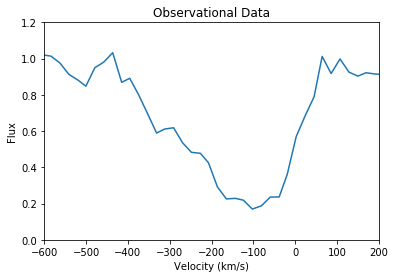

In [5]:
fig, ax = plt.subplots()
ax.plot(obsvels, flux)
ax.set_ylim(0, 1.2)
ax.set_xlim(-600, 200)
ax.set_title('Observational Data')
ax.set_ylabel('Flux')
ax.set_xlabel('Velocity (km/s)')

Now we need to write a funtion to calculate the absorption profiles from the simulation data! Write a function that takes the some constants; 

- velocity of the ion = vel_ion
- the width of the profile = b
- the average column density = N_avg

*** These constants are stored in the simulation data file and will be read in by the 'analysis' function

As well as variables you will give the function; 
- the covering fraction = f
- the list of velocities = vels


and calculates the flux from the equation in the paper you read! This function should return an array of fluxes over the list of velocities you pass to the function.

In [6]:
#function to calucate absorbtion profile
def flux_func(vel_ion, b, N_avg, f, vels):
    tau = ((c_speed/1.e5)*sigma)/(np.sqrt(np.pi)*b)*np.exp(-((vels + vel_ion)**2/b**2))
    sim_flux = (1-f) + f*np.exp(-1*tau*N_avg)
    return np.array(sim_flux)

Now we're ready to do some analysis! Define a variable with the name of the run you want to analyze, then call analysis passing it the run name, the data file from the simulations, the lists of velocities and fluxes from the observation. The analysis will return the best fit covering fraction, the chi for that best fit, the time of that fit, and a list of velocities. 

Then get the constants you need to calculate the flux with get_runData giving it the data file of the simulation data, the run name and the time. 

Use these constants and the best fit covering fraction to plot the best fit absorption profile! Add another line to plot the observed absorption profile, and adjust the plot to make it look nice :) 

T0.3_v1000_chi300 at time: 2
Best F value: 0.74 (Chi^2: 0.90)


Text(0.5, 0, 'Velocity (km/s)')

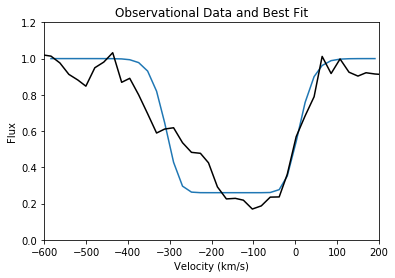

In [11]:
runTitle = 'T0.3_v1000_chi300'

bestf, chi, time, vels = analysis(runTitle, sim_data, obsvels, flux)
vel_ion, b, N_avg = get_runData(sim_data, runTitle, time)

fig, ax = plt.subplots(1,1)
ax.plot(vels, flux_func(vel_ion, b, N_avg, bestf, vels))
ax.plot(obsvels, flux, color = 'black')
ax.set_ylim(0, 1.2)
ax.set_xlim(-600, 200)
ax.set_title('Observational Data and Best Fit')
ax.set_ylabel('Flux')
ax.set_xlabel('Velocity (km/s)')

Now that you have calculated a best fit for one of the winds, try different winds! Do some fit better than others? Which one has the lowest chi squared fit? Which one has the highest covering fraction? What conclusions can you make looking at all of these? 

Bonus: Can you write some code for calculate the best fit for all of the different types of winds and then output the best fit of them all? 